In [ ]:
import cv2
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
import seaborn as sns


Спершу робимо передобробку датасету, бо він містить зображення, які оточені досить великим простором фону, а для моделі необхідні впритул обрізані зображення 

In [ ]:
def preprocess_image_db(img):
    coords = np.column_stack(np.where(img > 0))

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    cropped_img = img[x_min:x_max+1, y_min:y_max+1]
    cropped_img = np.array(cropped_img, dtype=np.uint8)

    padded_img = cv2.copyMakeBorder(cropped_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

    resized_img = cv2.resize(padded_img, (28, 28))

    return resized_img.flatten()


In [ ]:

df = pd.read_csv("uaset.csv")

processed_images = []

for index, row in df.iterrows():
    # print(index)
    # print(row)
    try:
        image = row[1:].values.reshape([28, 28])
        processed_image = preprocess_image_db(image)
        processed_images.append(processed_image.flatten())
    except:
        print(index)

processed_df = pd.DataFrame(processed_images, columns=df.columns[1:])
processed_df.insert(0, 'label', df['label'])

processed_df.to_csv("processed_uaset.csv", index=False)

### Приклад оброблених зображень

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9966 entries, 0 to 9965
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 59.7 MB
None


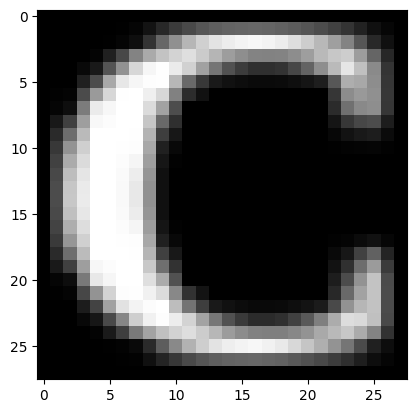

In [ ]:

df_processed = pd.read_csv("/content/processed_uaset.csv")
print(df.info())

k = 0  
plt.imshow(df_processed.iloc[1][1:].values.reshape([28, 28]), cmap='gray') 
plt.show()

## Загрузка датасета

In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

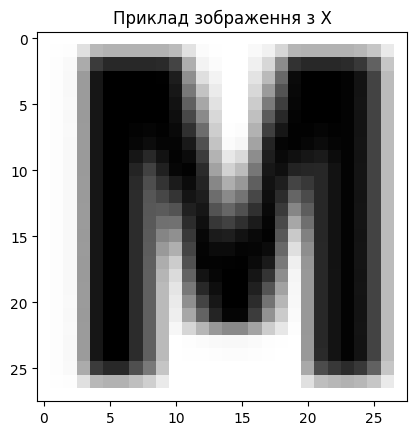

In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/processed_uaset.csv")

X = df[df.columns[1:]]
y = df['label']

X = X / 255.0

X = 1 - X

plt.imshow(X.values[0].reshape(28, 28), cmap='gray')
plt.title('Приклад зображення з X')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Розподіл кількості символів в навчальному наборі

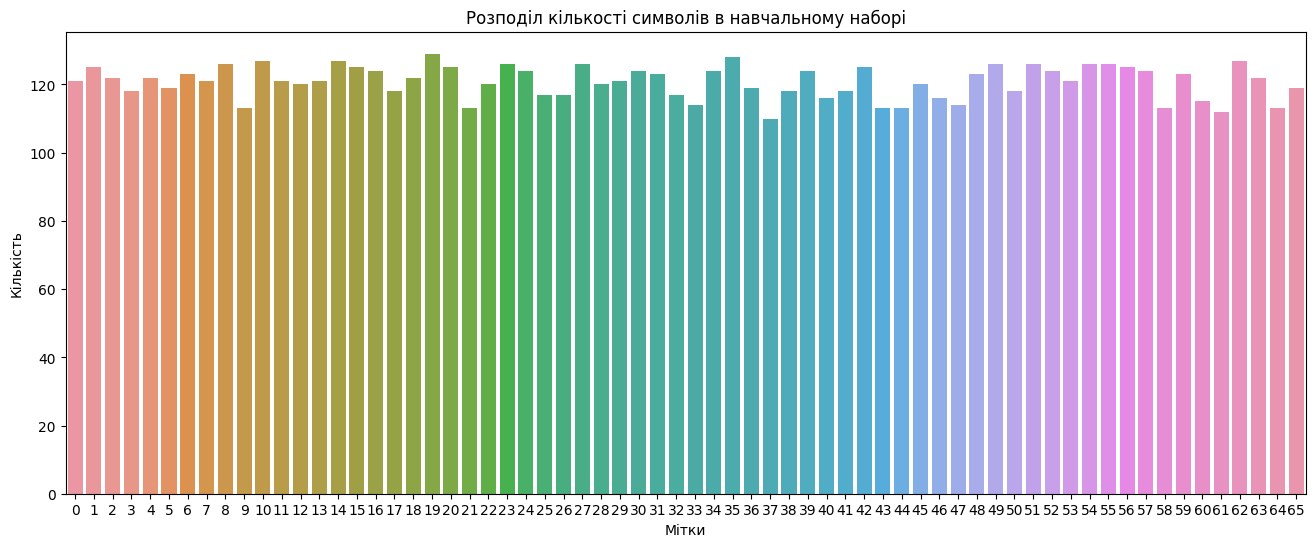

In [ ]:

y_train_labels = np.argmax(y_train, axis=1) # назад до оригінального значення
unique, counts = np.unique(y_train_labels, return_counts=True)

df_count = pd.DataFrame({'Label': unique, 'Count': counts})

plt.figure(figsize=(16, 6))
sns.barplot(x='Label', y='Count', data=df_count)
plt.title('Розподіл кількості символів в навчальному наборі')
plt.xlabel('Мітки')
plt.ylabel('Кількість')
plt.show()



## Демонстрація унікальних символів після обробки

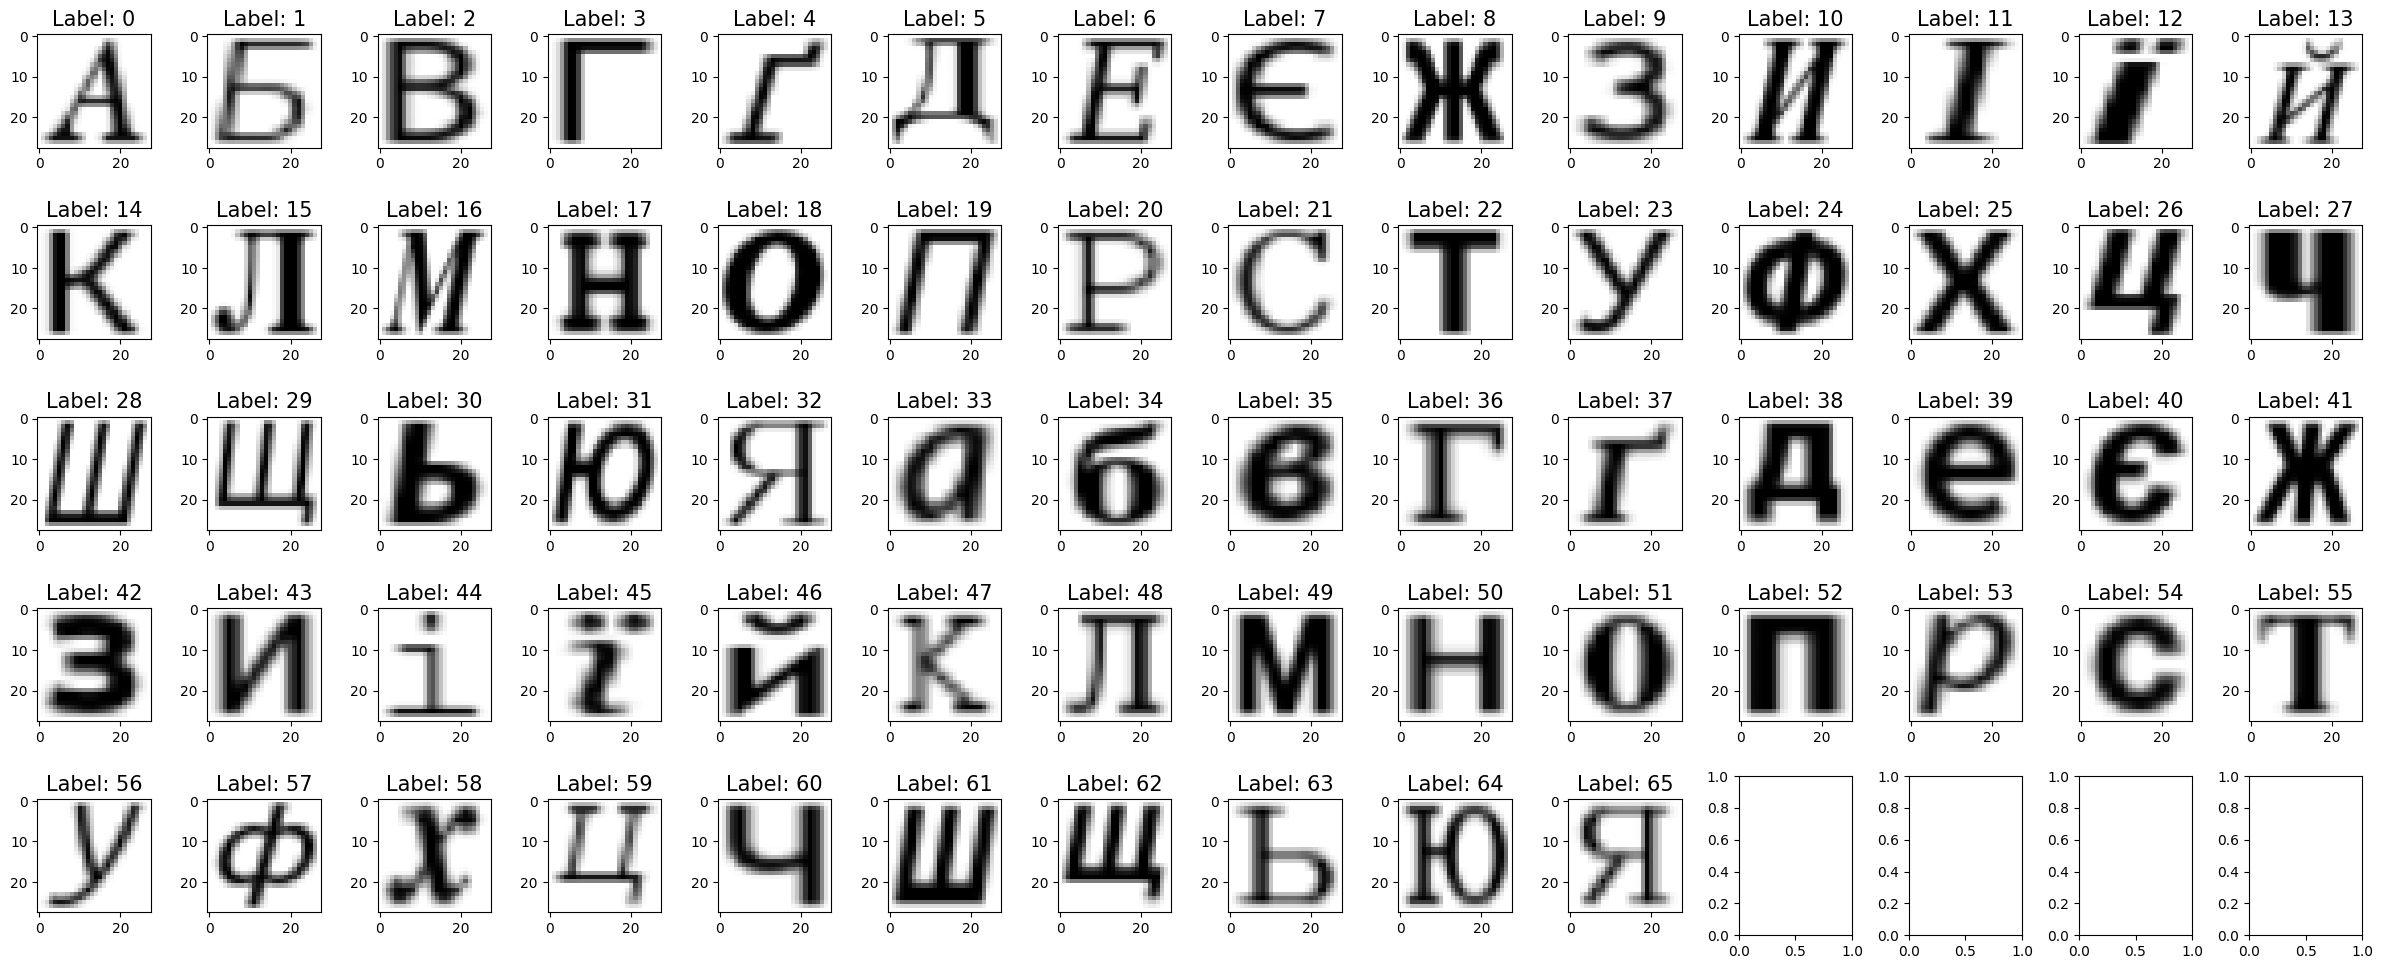

In [ ]:
def decode_one_hot(one_hot_vector):
    return np.argmax(one_hot_vector)

r = np.unique(y_train, axis=0)
r = [decode_one_hot(one_hot_vector) for one_hot_vector in r]
r.sort()

y_train_no_ohe = [decode_one_hot(one_hot_vector) for one_hot_vector in y_train]
unique_img = []
for i in r:
    unique_img.append(np.where(y_train_no_ohe == i)[0][0])

# print(unique_img)

def display_images(images):
    fig, axes = plt.subplots(5, 14, figsize=(30,12))  
    axes = axes.ravel() 
    for i in np.arange(0, len(images)):
        index = images[i]
        axes[i].imshow(X_train[index].reshape(28, 28), cmap='gray')
        label = decode_one_hot(y_train[index])
        axes[i].set_title(f"Label: {label}", fontsize=15)
        plt.subplots_adjust(wspace=0.5)
    plt.show()

display_images(unique_img)

## Аугментація даних 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
class ImageDataGeneratorWithNoise(ImageDataGenerator):
    def __init__(self, noise_stddev=0.1, **kwargs):
        super().__init__(**kwargs)
        self.noise_stddev = noise_stddev

    def random_transform(self, x):
        x = super().random_transform(x)
        noise = np.random.normal(scale=self.noise_stddev, size=x.shape)
        return np.clip(x + noise * 0.2, 0., 1.) 


datagen = ImageDataGeneratorWithNoise(
    zoom_range=0.2,
    # rotation_range=10,
    # width_shift_range=0.1,
    height_shift_range=0.3,
    # zoom_range=[0.5,1],
    noise_stddev=0.9 
)

datagen.fit(X_train)



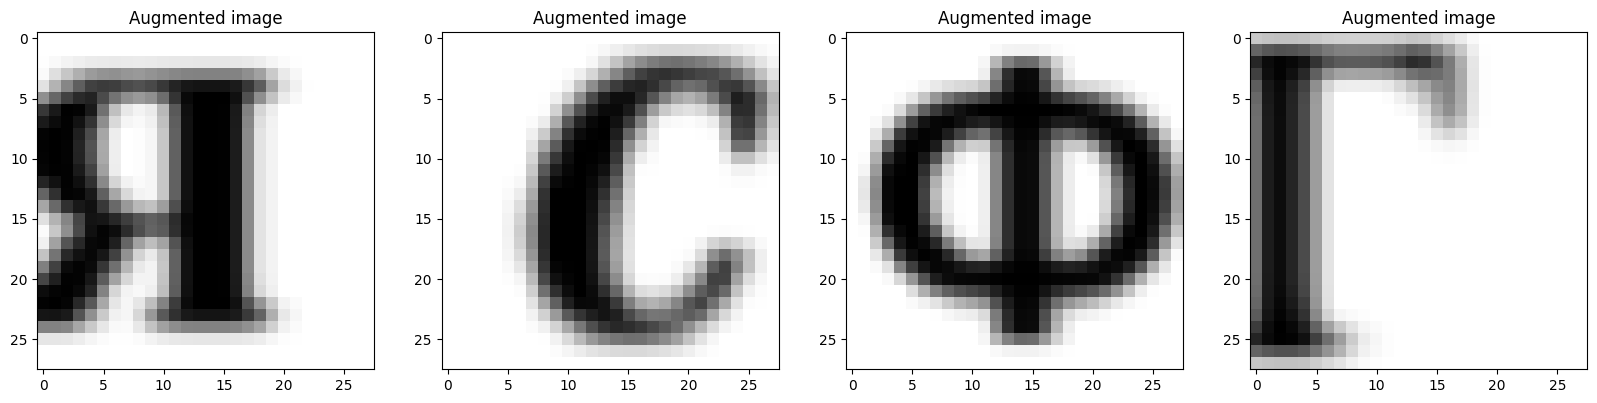

In [ ]:
images, labels = next(datagen.flow(X_train, y_train, batch_size=4))

fig, axes = plt.subplots(1, 4, figsize=(20,10))

for i in range(4):
    axes[i].imshow(images[i].squeeze(), cmap='gray')  
    axes[i].set_title('Augmented image')
plt.show()